#                                               SOCIAL NETWORK ANALYTICS

### DATASET TAKEN FROM: https://snap.stanford.edu/data/egonets-Facebook.html
### DATASET: facebook.tar.gz

### LOADING THE DATASET:

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import networkx as nx
import requests

BASE_URL = "https://raw.githubusercontent.com/AnanthaRam-GS/SocialNetworkAnalytics/main/datasets/"

edges_url = BASE_URL + "0.edges"
edges = pd.read_csv(edges_url, sep="\s+", header=None, names=["node1", "node2"], engine="python")

edges["node1"] = edges["node1"].astype(str).str.strip()
edges["node2"] = edges["node2"].astype(str).str.strip()

G = nx.from_pandas_edgelist(edges, "node1", "node2")

print("Edges loaded (fixed)")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

featnames = pd.read_csv(BASE_URL + "0.featnames", delim_whitespace=True, header=None, index_col=0)
featnames = featnames[1].tolist()

print("Feature names loaded")
print("Total features:", len(featnames))

features = pd.read_csv(BASE_URL + "0.feat", delim_whitespace=True, header=None)
features.columns = ["node_id"] + featnames
features["node_id"] = features["node_id"].astype(str) 

print("Features loaded")
print("Shape of features:", features.shape)

ego_features = pd.read_csv(BASE_URL + "0.egofeat", delim_whitespace=True, header=None)
ego_features.columns = featnames

print("Ego features loaded")
print("Shape of ego features:", ego_features.shape)

try:
    circles_url = BASE_URL + "0.circles"
    circles_raw = requests.get(circles_url).text.strip().split("\n")
    circles = [line.strip().split() for line in circles_raw if line.strip()]

    print("Circles loaded from GitHub")
    print(f"Number of circles: {len(circles)}")
    print("Example circle:", circles[0])
except Exception as e:
    print("Failed to load circles:", e)

Edges loaded (fixed)
Number of nodes: 333
Number of edges: 2519
Feature names loaded
Total features: 224
Features loaded
Shape of features: (347, 225)
Ego features loaded
Shape of ego features: (1, 224)
Circles loaded from GitHub
Number of circles: 24
Example circle: ['circle0', '71', '215', '54', '61', '298', '229', '81', '253', '193', '97', '264', '29', '132', '110', '163', '259', '183', '334', '245', '222']


### PRE-PROCESSING THE DATASET: 

In [4]:
print("Nodes in Graph:", len(G.nodes))
print("Rows in Features:", features.shape[0])
print("Missing values in features:", features.isnull().sum().sum())

# Drop columns that are all zeros
features = features.loc[:, (features != 0).any(axis=0)]
print("Features after dropping all-zero cols:", features.shape)

birthday_cols = [c for c in features.columns if "birthday" in c]
education_cols = [c for c in features.columns if "education" in c]
work_cols = [c for c in features.columns if "work" in c]

print("Birthday cols:", len(birthday_cols))
print("Education cols:", len(education_cols))
print("Work cols:", len(work_cols))

Nodes in Graph: 333
Rows in Features: 347
Missing values in features: 0
Features after dropping all-zero cols: (347, 225)
Birthday cols: 8
Education cols: 65
Work cols: 84


## QUESTION: 1 - What is the degree distribution of users in the ego network, and does it follow a heavy-tailed pattern similar to real social networks?

Explanation:
Degree of a node = number of connections (friends) that a user has.
In social networks (like Facebook, Twitter), degree distributions are often heavy-tailed or power-law:
    i) Most users have a moderate number of friends.
    ii) A few “hub” users have many friends.
This reflects real-world behavior: a small number of people are very social (influencers, connectors), while most are average.

Number of users: 333
Average degree: 15.13
Median degree: 10.0
Max degree: 77
Min degree: 1


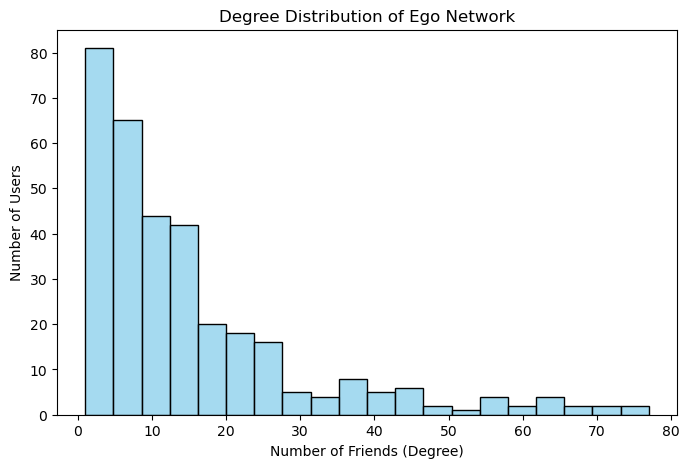

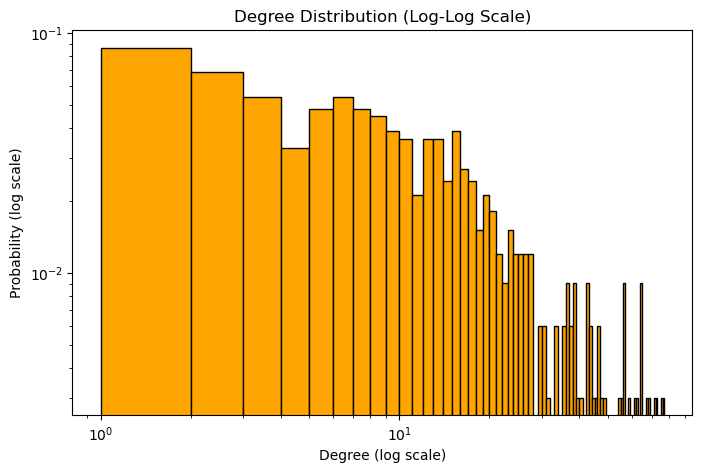

In [5]:
# Extract degree values
degree_dict = dict(G.degree())
degrees = list(degree_dict.values())

# Summary statistics
print("Number of users:", len(degrees))
print("Average degree:", round(np.mean(degrees), 2))
print("Median degree:", np.median(degrees))
print("Max degree:", np.max(degrees))
print("Min degree:", np.min(degrees))

# Histogram of degree distribution
plt.figure(figsize=(8,5))
sns.histplot(degrees, bins=20, kde=False, color="skyblue", edgecolor="black")
plt.title("Degree Distribution of Ego Network")
plt.xlabel("Number of Friends (Degree)")
plt.ylabel("Number of Users")
plt.show()

# Log-Log plot (to check heavy-tailed nature)
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=range(1, max(degrees)+1), density=True, log=True, color="orange", edgecolor="black")
plt.xscale("log")
plt.yscale("log")
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Probability (log scale)")
plt.show()

### QUESTION: 2 - Are there users who can be considered “hubs” (very high degree) or “isolates” (very low degree) compared to the average?

Explanation:
Hubs: Users with unusually many friends → influencers, connectors.
Isolates: Users with very few or no friends → less engaged.
Outlier detection here helps us:
    i) Spot special roles in the network.
    ii) Validate whether the network follows the hub-and-spoke structure typical of social graphs.

Outlier Detection:
Total users: 333
Potential outliers (|z| > 2): 19
Example outliers: ['122', '271', '304', '9', '252', '26', '239', '322', '56', '188']


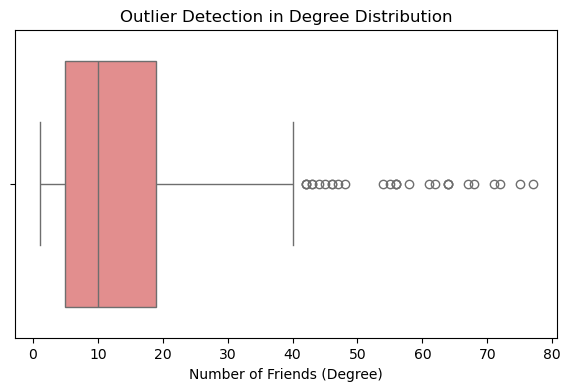

Hub users (max 77 friends): ['56']
Isolate users (min 1 friends): ['255', '70', '286', '33', '42', '279', '160', '234', '90', '216', '145', '282', '244', '233', '256', '138', '305', '153', '154', '198', '241', '267', '316', '205', '47', '183', '52', '34', '35']


In [6]:
from scipy.stats import zscore

# Get degrees
degree_dict = dict(G.degree())
degrees = np.array(list(degree_dict.values()))

# Z-score method for outliers
z_scores = zscore(degrees)
outlier_nodes = [node for node, z in zip(degree_dict.keys(), z_scores) if abs(z) > 2]

print("Outlier Detection:")
print("Total users:", len(degrees))
print("Potential outliers (|z| > 2):", len(outlier_nodes))
print("Example outliers:", outlier_nodes[:10])  # show first few

# Visualize with boxplot
plt.figure(figsize=(7,4))
sns.boxplot(x=degrees, color="lightcoral")
plt.title("Outlier Detection in Degree Distribution")
plt.xlabel("Number of Friends (Degree)")
plt.show()

# Highlight hubs and isolates
max_degree = np.max(degrees)
min_degree = np.min(degrees)

hub_users = [n for n, d in degree_dict.items() if d == max_degree]
isolate_users = [n for n, d in degree_dict.items() if d == min_degree]

print(f"Hub users (max {max_degree} friends): {hub_users}")
print(f"Isolate users (min {min_degree} friends): {isolate_users}")

### QUESTION: 3 - If we randomly sample 20% of the users, does the degree distribution of the sample accurately reflect the overall population distribution?

In Data Science, we often can’t analyze the entire dataset → we use samples.
The question is whether a sample is representative of the population.
Here:
    Population → all users in the ego network.
    Sample → randomly selected 20% of users.
We compare degree distributions (population vs sample).

Sampling Info:
Population size: 333
Sample size: 66
Population mean degree: 15.13
Sample mean degree: 15.86


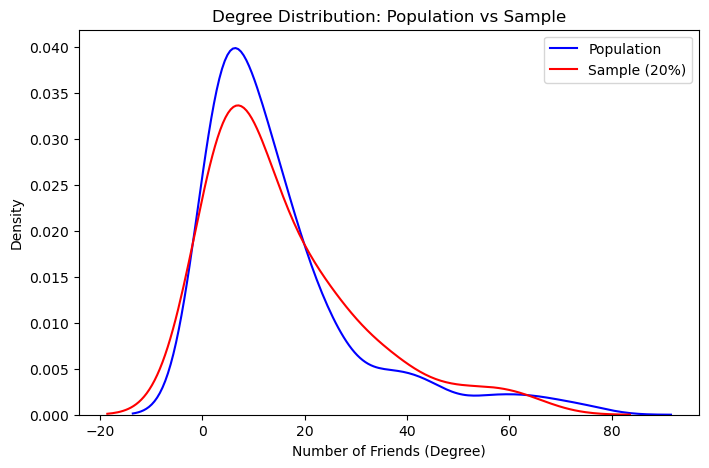


Kolmogorov-Smirnov Test
Statistic: 0.084
p-value: 0.799
Sample distribution is similar to population (fail to reject H0).


In [7]:
import random
from scipy.stats import ks_2samp

# Full degree distribution
degree_dict = dict(G.degree())
all_nodes = list(degree_dict.keys())
all_degrees = np.array(list(degree_dict.values()))

# Randomly sample 20% of nodes
sample_size = int(0.2 * len(all_nodes))
sample_nodes = random.sample(all_nodes, sample_size)
sample_degrees = np.array([degree_dict[n] for n in sample_nodes])

print("Sampling Info:")
print("Population size:", len(all_nodes))
print("Sample size:", sample_size)
print("Population mean degree:", round(np.mean(all_degrees), 2))
print("Sample mean degree:", round(np.mean(sample_degrees), 2))

# Compare distributions visually
plt.figure(figsize=(8,5))
sns.kdeplot(all_degrees, label="Population", color="blue")
sns.kdeplot(sample_degrees, label="Sample (20%)", color="red")
plt.title("Degree Distribution: Population vs Sample")
plt.xlabel("Number of Friends (Degree)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Statistical test: KS test
stat, p_value = ks_2samp(all_degrees, sample_degrees)
print("\nKolmogorov-Smirnov Test")
print("Statistic:", round(stat, 3))
print("p-value:", round(p_value, 3))

if p_value > 0.05:
    print("Sample distribution is similar to population (fail to reject H0).")
else:
    print("Sample distribution differs significantly from population (reject H0).")

### QUESTION: 4 - Do users with common “education” attributes tend to form denser communities compared to others?

Explanation:
Homophily = “birds of a feather flock together.”
In social networks, people with similar background (like same school/college) are more likely to be connected.
Here, we check whether users who share education features are more tightly connected.
Approach:
    i) Identify nodes with education-related features.
    ii) Extract subgraph of these users.
Compare density of subgraph vs overall graph.

Education Homophily Analysis
Users with education features: 261
Edges among them: 1423
Overall network density: 0.0456
Education subgraph density: 0.0457


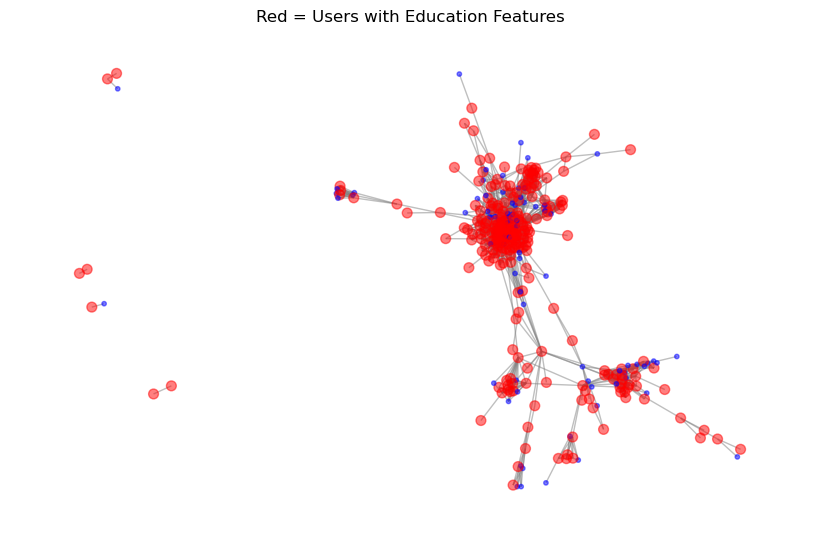

In [8]:
# Select education-related columns
education_cols = [c for c in features.columns if "education" in c]

# Find users with at least one education attribute
edu_users = features.loc[features[education_cols].sum(axis=1) > 0, "node_id"].astype(str).tolist()

# Subgraph of education users
G_edu = G.subgraph(edu_users)

print("Education Homophily Analysis")
print("Users with education features:", len(edu_users))
print("Edges among them:", G_edu.number_of_edges())

# Graph density = actual edges / possible edges
overall_density = nx.density(G)
edu_density = nx.density(G_edu)

print("Overall network density:", round(overall_density, 4))
print("Education subgraph density:", round(edu_density, 4))

# Visualization: Education subgraph vs full network
plt.figure(figsize=(8,5))
sizes = [50 if n in edu_users else 10 for n in G.nodes()]
colors = ["red" if n in edu_users else "blue" for n in G.nodes()]
nx.draw(G, node_size=sizes, node_color=colors, edge_color="gray", alpha=0.5, with_labels=False)
plt.title("Red = Users with Education Features")
plt.show()

### QUESTION: 5 - Is the mean number of friends for users with work-related features significantly different from those without?

Explanation:
Hypothesis testing framework:
    i) Null Hypothesis (H₀): Mean degree (friends) of users with work features = Mean degree of users without work features.
    ii) Alternative Hypothesis (H₁): The two means are significantly different.

Work Attribute Analysis
Users with work features: 164
Users without work features: 169
Mean degree (work): 17.74
Mean degree (non-work): 12.59

T-test results
t-statistic: 3.054
p-value: 0.0024
Reject H₀ → Significant difference in connectivity.


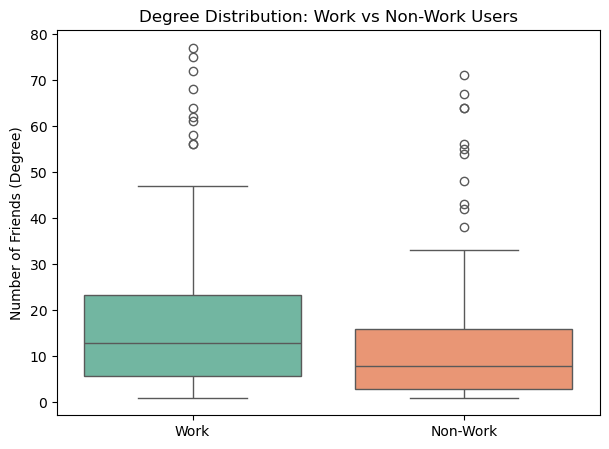

In [9]:
from scipy.stats import ttest_ind

# Select work-related columns
work_cols = [c for c in features.columns if "work" in c]

# Classify users into work vs non-work
work_users = features.loc[features[work_cols].sum(axis=1) > 0, "node_id"].astype(str).tolist()
nonwork_users = features.loc[features[work_cols].sum(axis=1) == 0, "node_id"].astype(str).tolist()

# Get degrees
degree_dict = dict(G.degree())
work_degrees = [degree_dict[n] for n in work_users if n in degree_dict]
nonwork_degrees = [degree_dict[n] for n in nonwork_users if n in degree_dict]

print("Work Attribute Analysis")
print("Users with work features:", len(work_degrees))
print("Users without work features:", len(nonwork_degrees))
print("Mean degree (work):", round(np.mean(work_degrees), 2))
print("Mean degree (non-work):", round(np.mean(nonwork_degrees), 2))

# Hypothesis test: independent t-test
t_stat, p_val = ttest_ind(work_degrees, nonwork_degrees, equal_var=False)

print("\nT-test results")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_val, 4))

if p_val < 0.05:
    print("Reject H₀ → Significant difference in connectivity.")
else:
    print("Fail to reject H₀ → No significant difference detected.")

df_work = pd.DataFrame({
    "degree": work_degrees,
    "group": "Work"
})

df_nonwork = pd.DataFrame({
    "degree": nonwork_degrees,
    "group": "Non-Work"
})

df_combined = pd.concat([df_work, df_nonwork])

# Boxplot comparison
plt.figure(figsize=(7,5))
sns.boxplot(x="group", y="degree", data=df_combined, palette="Set2")
plt.title("Degree Distribution: Work vs Non-Work Users")
plt.ylabel("Number of Friends (Degree)")
plt.xlabel("")
plt.show()

### Question: 6 - Is there a statistically significant association between users belonging to the same birthday group and their likelihood of being in the same friend circle?

Explanation:
People often connect with peers of the same age group (schoolmates, batchmates).
This is homophily based on age/birthday.

Method:
    i) Identify users’ birthday features.
    ii) Cross-tabulate with circle membership.
    iii) Run a Chi-Square test of independence.

Null Hypothesis (H₀): Birthday group and circle membership are independent.
Alternative Hypothesis (H₁): They are associated.

In [25]:
from scipy.stats import chi2_contingency

birthday_cols = [c for c in features.columns if "birthday" in c]

features["has_birthday"] = (features[birthday_cols].sum(axis=1) > 0).astype(int)

circle_file = "datasets/0.circles"
circle_map = {}
with open(circle_file) as f:
    for i, line in enumerate(f):
        members = line.strip().split()[1:]
        for m in members:
            circle_map[m] = f"circle_{i+1}"

# Add circle info to features
features["circle"] = features["node_id"].astype(str).map(circle_map).fillna("NoCircle")

contingency_table = pd.crosstab(features["has_birthday"], features["circle"])

print("Contingency Table:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results")
print("Chi2 statistic:", round(chi2, 3))
print("Degrees of freedom:", dof)
print("p-value:", round(p, 4))

if p < 0.05:
    print("Reject H₀ → Birthday group is associated with circle membership.")
else:
    print("Fail to reject H₀ → No significant association detected.")

contingency_table.T.plot(kind="bar", stacked=True, figsize=(8,5), colormap="viridis")
plt.title("Circle Membership vs Birthday Info")
plt.ylabel("Number of Users")
plt.xlabel("Circles")
plt.show()

TypeError: argument of type 'int' is not iterable

### Question: 7 - Do two different circles (e.g., Circle A vs Circle B) show a significant difference in their average number of connections (degree)?

Explanation:

Not all friend circles are equally connected.
Example: Work circle might be less connected than college friends circle.

Method:
    i) Pick two circles from 0.circles.
    ii) Get the degree (number of friends) of users in each circle.
    iii) Use a two-sample t-test → compare mean degrees.

Null Hypothesis (H₀): Circle A and Circle B have the same mean degree.
Alternative Hypothesis (H₁): Their mean degrees differ significantly.

In [27]:
# Load circles
circle_file = "datasets/0.circles"
circles = {}
with open(circle_file) as f:
    for i, line in enumerate(f):
        parts = line.strip().split()
        circle_name = f"circle_{i+1}"
        members = parts[1:]
        circles[circle_name] = members

print("Available Circles:", list(circles.keys()))

circleA, circleB = list(circles.keys())[:2]

# Get degrees of users in each circle
degree_dict = dict(G.degree())
circleA_degrees = [degree_dict[n] for n in circles[circleA] if n in degree_dict]
circleB_degrees = [degree_dict[n] for n in circles[circleB] if n in degree_dict]

print(f"\nCircle A ({circleA}): {len(circleA_degrees)} users")
print(f"Mean degree: {np.mean(circleA_degrees):.2f}")
print(f"\nCircle B ({circleB}): {len(circleB_degrees)} users")
print(f"Mean degree: {np.mean(circleB_degrees):.2f}")

# Two-sample t-test
t_stat, p_val = ttest_ind(circleA_degrees, circleB_degrees, equal_var=False)

print("\nT-test Results")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_val, 4))

if p_val < 0.05:
    print("Reject H₀ → Circles differ significantly in average connectivity.")
else:
    print("Fail to reject H₀ → No significant difference between circles.")

Available Circles: ['circle_1', 'circle_2', 'circle_3', 'circle_4', 'circle_5', 'circle_6', 'circle_7', 'circle_8', 'circle_9', 'circle_10', 'circle_11', 'circle_12', 'circle_13', 'circle_14', 'circle_15', 'circle_16', 'circle_17', 'circle_18', 'circle_19', 'circle_20', 'circle_21', 'circle_22', 'circle_23', 'circle_24']

Circle A (circle_1): 19 users
Mean degree: 6.58

Circle B (circle_2): 1 users
Mean degree: 5.00

T-test Results
t-statistic: nan
p-value: nan
Fail to reject H₀ → No significant difference between circles.


### Question: 8 - Can a user’s number of friends (degree) be predicted from their profile attributes such as education, work, and birthday features?

Explanation:
Here, dependent variable (Y): degree (#friends).
Independent variables (X): profile attributes (education, work, birthday).
We’ll use linear regression to check:
    i) How well attributes explain connectivity.
    ii) Which features contribute the most.

Shape of features: (347, 225)
   node_id  birthday;anonymized  birthday;anonymized  birthday;anonymized  \
0        1                    0                    0                    0   
1        2                    0                    0                    0   
2        3                    0                    0                    0   
3        4                    0                    0                    0   
4        5                    0                    0                    0   

   birthday;anonymized  birthday;anonymized  birthday;anonymized  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   birthday;anonymized  birthday;anonymized  education;classes;id;anonymized  \
0                 

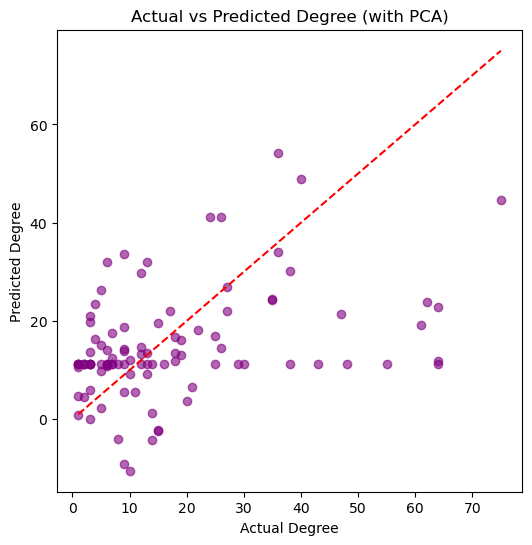

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

featnames = pd.read_csv("datasets/0.featnames", sep=" ", header=None, index_col=0)
featnames = featnames[1].tolist()

features = pd.read_csv("datasets/0.feat", sep=" ", header=None)
features.columns = ["node_id"] + featnames

print("Shape of features:", features.shape)
print(features.head())

edu_cols = [c for c in features.columns if "education" in c]
work_cols = [c for c in features.columns if "work" in c]
bday_cols = [c for c in features.columns if "birthday" in c]

selected_cols = edu_cols + work_cols + bday_cols

features["node_id"] = features["node_id"].astype(str)

degree_dict = dict(G.degree())
features["degree"] = features["node_id"].map(degree_dict)

print("Before cleaning:", features.shape)
print("Non-null degrees:", features["degree"].notna().sum())

# Drop rows with NaN degree
features = features.dropna(subset=["degree"]).reset_index(drop=True)

print("After cleaning:", features.shape)
print(features[["node_id", "degree"]].head())

if len(selected_cols) == 0:
    selected_cols = [c for c in features.columns if c not in ["node_id", "degree"]]
    print("No education/work/birthday features found. Using all features instead.")

X = features[selected_cols]
y = features["degree"]

print("Shape of X before PCA:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and X.shape[1] > 0:
    pca = PCA(n_components=30) 
    X_reduced = pca.fit_transform(X)

    print("Shape of X after PCA:", X_reduced.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42
    )

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("\nRegression Results with PCA (30 components):")
    print("R² score:", round(r2, 3))
    print("Mean Squared Error:", round(mse, 3))

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
    plt.xlabel("Actual Degree")
    plt.ylabel("Predicted Degree")
    plt.title("Actual vs Predicted Degree (with PCA)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') 
    plt.show()

else:
    print("No valid features or samples found for regression.")

### Question: 9 - Visualize the distribution of communities detected in the network. How many communities exist, and what is the size of each?

Explanation:
Communities represent clusters of users who are more connected to each other than to the rest of the network.
Detecting them helps us understand social groups: close friends, work colleagues, family circles, etc.
We’ll use the Greedy Modularity algorithm (greedy_modularity_communities from NetworkX) to detect communities.
Then, we’ll visualize the distribution of community sizes using a bar plot.

Number of communities detected: 12
Community 1: 119 members
Community 2: 52 members
Community 3: 47 members
Community 4: 33 members
Community 5: 32 members
Community 6: 23 members
Community 7: 10 members
Community 8: 8 members
Community 9: 3 members
Community 10: 2 members


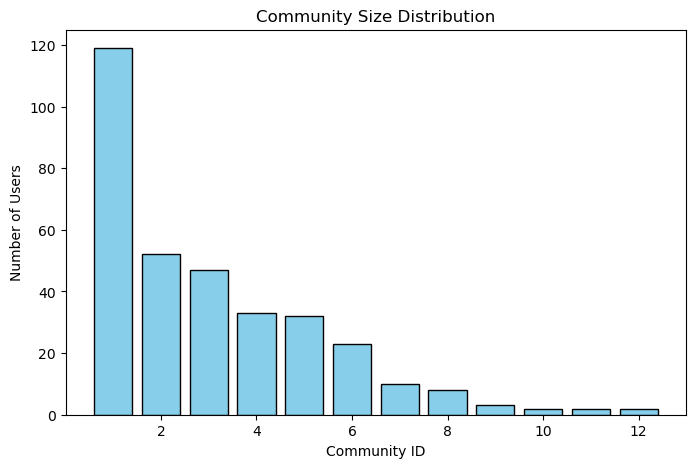

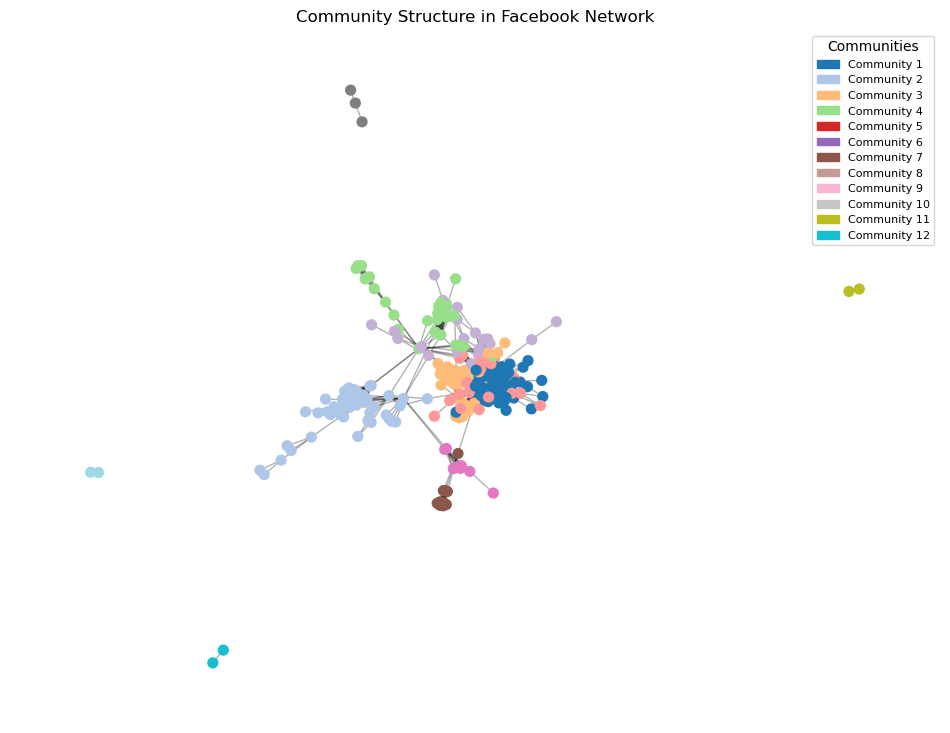

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.patches as mpatches

communities = list(greedy_modularity_communities(G))

print(f"Number of communities detected: {len(communities)}")

# Calculate community sizes
community_sizes = [len(c) for c in communities]

for i, size in enumerate(community_sizes[:10], start=1):
    print(f"Community {i}: {size} members")

plt.figure(figsize=(8,5))
plt.bar(range(1, len(communities)+1), community_sizes, color="skyblue", edgecolor="black")
plt.xlabel("Community ID")
plt.ylabel("Number of Users")
plt.title("Community Size Distribution")
plt.show()

# Assign community index to each node
node_community = {}
for i, com in enumerate(communities):
    for node in com:
        node_community[node] = i

# Position nodes with spring layout
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12,9))

# Draw nodes colored by community
colors = [node_community[n] for n in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color=colors,
    cmap=plt.cm.tab20  
)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Create legend patches
unique_coms = sorted(set(node_community.values()))
patches = [mpatches.Patch(color=plt.cm.tab20(i/len(unique_coms)), label=f"Community {i+1}") 
           for i in unique_coms]

plt.legend(handles=patches, loc="best", title="Communities", fontsize=8)
plt.title("Community Structure in Facebook Network")
plt.axis("off")
plt.show()

### Question: 10 - Visualize the ego network of the main user (ego node) and their immediate connections. What insights can be drawn about their direct social circle?

Explanation:
The dataset is an ego network (centered on one Facebook user).
The ego node represents the main user, and the edges represent friendships.
Analyzing this structure helps us see how their direct friends are connected:
    Is it one tight-knit group (everyone knows each other)?
    Or many disjoint groups (work friends, school friends, etc.)?
Visualization will highlight the ego (center node) and their immediate connections.

Ego Node: 236
Number of nodes in ego network: 37
Number of edges in ego network: 273


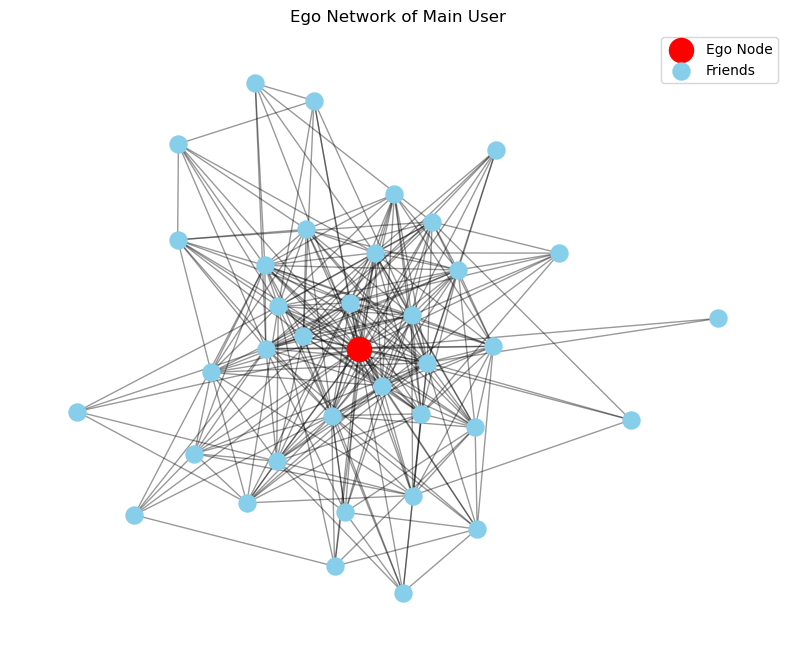

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

ego_node = "0" 
if ego_node not in G.nodes():
    ego_node = list(G.nodes())[0] 

print(f"Ego Node: {ego_node}")

ego_net = nx.ego_graph(G, ego_node, radius=1) 

print(f"Number of nodes in ego network: {ego_net.number_of_nodes()}")
print(f"Number of edges in ego network: {ego_net.number_of_edges()}")

pos = nx.spring_layout(ego_net, seed=42)

plt.figure(figsize=(10,8))

# Draw ego node in red
nx.draw_networkx_nodes(ego_net, pos,
                       nodelist=[ego_node],
                       node_size=300,
                       node_color="red",
                       label="Ego Node")

# Draw friends in blue
nx.draw_networkx_nodes(ego_net, pos,
                       nodelist=[n for n in ego_net.nodes() if n != ego_node],
                       node_size=150,
                       node_color="skyblue",
                       label="Friends")

# Draw edges
nx.draw_networkx_edges(ego_net, pos, alpha=0.4)

plt.title("Ego Network of Main User")
plt.legend()
plt.axis("off")
plt.show()

In [21]:
import pandas as pd
from IPython.display import HTML

# Custom Pandas table style
def style_table(df, title):
    styled = df.head(10).style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1a1a2e'), ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'td', 'props': [('background-color', '#0f3460'), ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#16213e')]},
    ]).set_caption(title)
    return styled

# Example: Display your dataset
style_table(edges.head(10), "datasets/0.edges")
display(style_table(edges, "Facebook Edges Dataset"))

,node1,node2
0,236,186
1,122,285
2,24,346
3,271,304
4,176,9
5,130,329
6,204,213
7,252,332
8,82,65
9,276,26


In [22]:
import pandas as pd
from IPython.display import display, HTML

# Custom table style
def style_table(df, title):
    styled = df.head(10).style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1a1a2e'), ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'td', 'props': [('background-color', '#0f3460'), ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#16213e')]}
    ]).set_caption(title)
    return styled

# 🔹 Load the Circles dataset properly
circles = pd.read_csv("datasets/0.circles", sep=" ", header=None)
circles.columns = ["CircleName"] + [f"Member_{i}" for i in range(1, circles.shape[1])]
display(style_table(circles, "Facebook Circles Dataset"))


,CircleName
0,circle0 71 215 54 61 298 229 81 253 193 97 264 29 132 110 163 259 183 334 245 222
1,circle1 173
2,circle2 155 99 327 140 116 147 144 150 270
3,circle3 51 83 237
4,circle4 125 344 295 257 55 122 223 59 268 280 84 156 258 236 250 239 69
5,circle5 23
6,circle6 337 289 93 17 111 52 137 343 192 35 326 310 214 32 115 321 209 312 41 20
7,circle7 225 46
8,circle8 282
9,circle9 336 204 74 206 292 146 154 164 279 73


In [24]:
import pandas as pd
from IPython.display import display, HTML

# === Styling function ===
def style_table(df, title):
    styled = df.head(10).style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1a1a2e'),
                                     ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'td', 'props': [('background-color', '#0f3460'),
                                     ('color', 'white'), ('font-size', '12px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#16213e')]}
    ]).set_caption(title)
    return styled


# === 1. Edges dataset (friend connections) ===
edges = pd.read_csv("datasets/0.edges", sep=" ", names=["node1", "node2"])
display(style_table(edges, "Facebook Edges Dataset"))

# === 2. Circles dataset (friend groups) ===
circles = pd.read_csv("datasets/0.circles", sep=" ", header=None)
circles.columns = ["CircleName"] + [f"Member_{i}" for i in range(1, circles.shape[1])]
display(style_table(circles, "Facebook Circles Dataset"))

# === 3. Features dataset (user attributes) ===
features = pd.read_csv("datasets/0.feat", sep=" ", header=None)
display(style_table(features, "Facebook Features Dataset"))

# === 4. Ego features dataset (main user's own attributes) ===
egofeat = pd.read_csv("datasets/0.egofeat", sep=" ", header=None)
display(style_table(egofeat, "Facebook Ego Feature Dataset"))

# === 5. Feature names (description of features) ===
featnames = pd.read_csv("datasets/0.featnames", sep=" ", header=None, names=["FeatureID", "FeatureName"])
display(style_table(featnames, "Facebook Feature Names Dataset"))

,node1,node2
0,236,186
1,122,285
2,24,346
3,271,304
4,176,9
5,130,329
6,204,213
7,252,332
8,82,65
9,276,26


,CircleName
0,circle0 71 215 54 61 298 229 81 253 193 97 264 29 132 110 163 259 183 334 245 222
1,circle1 173
2,circle2 155 99 327 140 116 147 144 150 270
3,circle3 51 83 237
4,circle4 125 344 295 257 55 122 223 59 268 280 84 156 258 236 250 239 69
5,circle5 23
6,circle6 337 289 93 17 111 52 137 343 192 35 326 310 214 32 115 321 209 312 41 20
7,circle7 225 46
8,circle8 282
9,circle9 336 204 74 206 292 146 154 164 279 73


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0


,,FeatureID,FeatureName
0,birthday;anonymized,feature,0
1,birthday;anonymized,feature,1
2,birthday;anonymized,feature,2
3,birthday;anonymized,feature,3
4,birthday;anonymized,feature,4
5,birthday;anonymized,feature,5
6,birthday;anonymized,feature,6
7,birthday;anonymized,feature,7
8,education;classes;id;anonymized,feature,8
9,education;classes;id;anonymized,feature,9
